# Short introduction to the course
## Short remarks
short intro to the aim of the course
short Intro to Python,  Python packages, installing and packages
how to run a jupyter notebook
download images



## Define the image Analysis problem



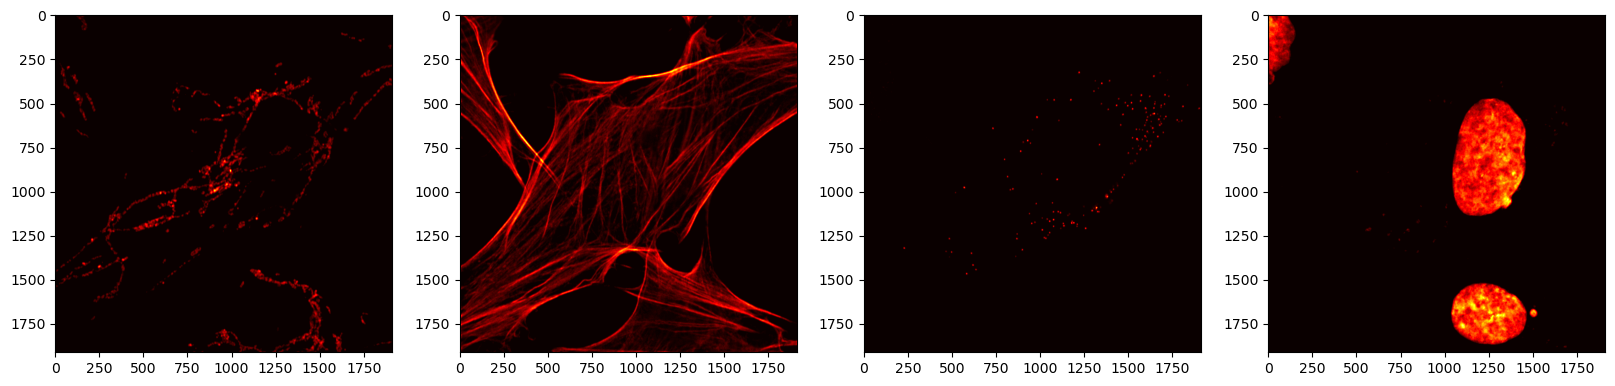

In [2]:

from aicsimageio import AICSImage
import matplotlib.pyplot as plt

file = AICSImage('data/airyscan-4colors.tif')
img = file.data
img = img[0,:,0,:,:]
# define the colormap
cmp=['hot']
# display each channel
fig, axs = plt.subplots(1, 4)
ax0=axs[0].imshow(img[0,:,:], plt.colormaps['hot']) 
ax1=axs[1].imshow(img[1,:,:], plt.colormaps['hot'])    
ax2=axs[2].imshow(img[2,:,:], plt.colormaps['hot'])    
ax3=axs[3].imshow(img[3,:,:], plt.colormaps['hot'])       
fig.set_size_inches(20, 5)

 Let say we are interested in what is happening in each channel within the actin region (Channel-1) that surround each nucleus (Channel-3). Our region of interest (ROI) is therefore defined by the region delimited by the actins in Channel-1 that have as a "seed" the nuclei in Channel-3. We want to measure:
- the maximal intensity in Channel-0 within this ROI,
- the integrated intensity in Channel-1 within this ROI,
- the median intensity of Channel-2 of the ROI within this ROI  

That is enough problem for now so let's get into it :)

To solve the problem and achieve the statistic analysis, we generally need to do the following steps:
- Load the image
- Filter the image
- Segment the image
- Measure image properties
- Save the data


 
This notebook shows how can we extract statistical information from an image (e.g. finding the maximal intensity in a desired region of interest). The steps that we need to follow to achieve this mainly depend on the exact problem we want to solve but in general it consists of: 

    Step 1: load and read the image (load-data.ipynb)
    Step 2: pre-process the image if necessary such as noise filtering (filter-image.ipynb)
    Step 3: find the region of interest: edge or inside the region? 
    Step 4: extract the desired information in the region of interest: mean, max, min, sum, median, mode, ...
    Step 5: display/plot results
    Step 6: save the result in a given image format or values in a text/excel file

# Load Image Data

- How to load an image explain that there are different packages for different image types

- We use aicsimageio - Why?, Depending on your image format you can use a different package

- explain bioformats



In [3]:
# IMPORT PACKAGES -- can this be simplified?

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib.colors  import LinearSegmentedColormap, ListedColormap

- you need to specify the path of the image

- Load the image with its metadata in this next cell by replacing the image path directory in that cell. Make sure to have the path correct and use / instead of \


In [4]:
from aicsimageio import AICSImage
mydata =  AICSImage('data/airyscan-4colors.tif')

The image and its metadata is now loaded into the variable "mydata".



What is metadata.
Next, we read the image and the metadata. Metadata includes the number of channels in the images, the name of each channel and emission wavelength associated with each channel, the voxel size and physical size of the image. Many other acquisition parameters are stored in the metadata and we can access them from here.


In [5]:
#Leave out metadata alltogether? this dictionary is a bit complicated


metadata = mydata.metadata                           

print(metadata)

img = AICSImage('data/tetrahymena.nd2')
data = img.data
for k, i in enumerate(img.dims.order):
    print(f'Array axis {k} is {i} with size {img.dims[i][0]}')
print(f'The name of the channels are {img.channel_names}')
print(f'The pixel size in X is {img.physical_pixel_sizes.X} microns')
print(f'The pixel size in Y is {img.physical_pixel_sizes.Y} microns')


ImageJ=1.53t
images=4
channels=4
mode=composite
unit=micron
loop=false
min=1.0
max=8.0
Array axis 0 is T with size 60
Array axis 1 is C with size 1
Array axis 2 is Z with size 1
Array axis 3 is Y with size 256
Array axis 4 is X with size 256
The name of the channels are ['DIC Camera']
The pixel size in X is 0.21666666666666667 microns
The pixel size in Y is 0.21666666666666667 microns


- now lets extract image data and look at it.
- what is an image?
- explain image dimensions


(-0.5, 19.5, 19.5, -0.5)

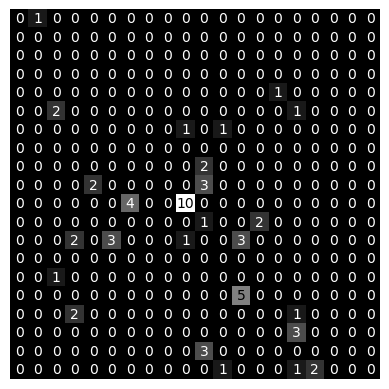

In [6]:
#illustration of image array

import numpy as np
img = AICSImage('data/airyscan-4colors.tif')
image = img.data[0,0,0,::100,::100]
fig, ax = plt.subplots(1)
plt.imshow(image, cmap='gray')
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        c = 'white' if image[i, j] < 5 else 'black'
        ax.text(j, i, str(int(image[i, j])), color=c, ha='center', va='center', size=10)
ax.axis("off")

(1, 4, 1, 1912, 1912)
<class 'numpy.ndarray'>


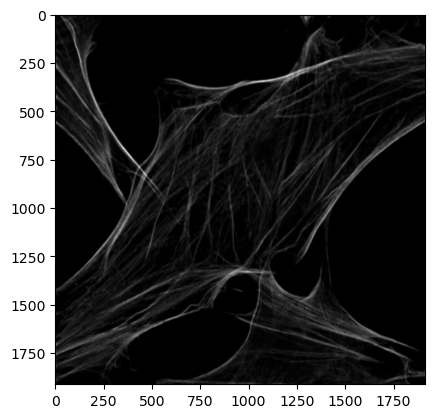

In [8]:
image = mydata.data

print(image.shape)    #explain shape of the image
print(type(image)) 


#Look at the images

fig, ax = plt.subplots()
ax.imshow(image[0,1,0,:,:], cmap='gray')

#exercise, change the timepoint, change the colormap 

# Image Filtering and Noise

Noise in microscopic image is unavoidable during image acquisition. There are three main categories of noise: 
1)Photon noise, also called fluorescence noise or shot noise: acquired due to the fluctuation of photon emission to the detector. This is the most dominant noise. It is signal dependent and follows a Poisson distribution. 
2) Electronic noise, also called dark current or dark noise: accumulated over time due to thermal change as the detector heats up. It is unavoidable but negligible compared to photon noise and is not photon dependent. It follows Poisson distribution. 
3) Readout noise: digital noise acquired during the electronic quantisation of photons. It follows a Gaussian distribution where the standard deviation is constant and the mean is 0.

Dominant noise in fluorescence microscopy follows either a Gaussian distribution or Poisson distribution or both. Gaussian noise is additive while Poisson noise is signal dependent. A correct removal of those two different types of noise may therefore differ. Firstly, we will look at how those noise affect the image differently. 

In [10]:
# LOAD PACKAGES
from aicsimageio import AICSImage   # for reading the image
import numpy as np                  # for operations on arrays
import matplotlib.pyplot as plt     # for plotting/display 


# Load data again to make sure we are all working on the same image
mydata =  AICSImage('data/airyscan-4colors.tif')
myimg = mydata.data
myimg = mydata.data[0,:,0,:,:]  # select all channels at t = 0 and z = 0  
imgsize = myimg.shape           # image size

## Add Noise to an image

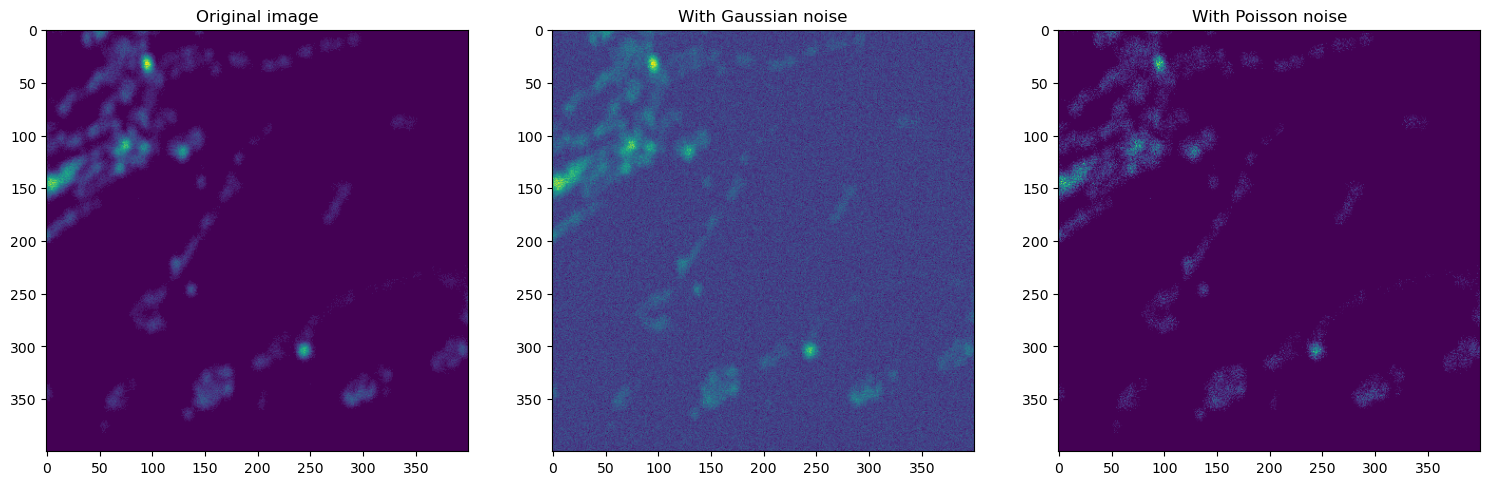

In [11]:
# Genereate RANDOM GAUSSIAN NOISE

EdgeCoord = [850,1250,900,1300] # y-up, y-down, x-left, x-right 
myimgzoom = myimg[:,EdgeCoord[0]:EdgeCoord[1],EdgeCoord[2]:EdgeCoord[3]]


mean = 0
stddev = 1
noisy_gauss_img = myimgzoom + np.random.normal(mean, stddev, myimgzoom.shape)


# APPLY POISSON NOISE
noisy_poisson_img = np.random.poisson(myimgzoom)

fig, axs = plt.subplots(1, 3)
ax1=axs[0].imshow(myimgzoom[0,:,:])              # original image
ax2=axs[1].imshow(noisy_gauss_img[0,:,:])    # with addition Gaussian noise
ax3=axs[2].imshow(noisy_poisson_img[0,:,:])  # after application of Poisson noise
axs[0].set_title('Original image')
axs[1].set_title('With Gaussian noise')
axs[2].set_title('With Poisson noise')
fig.set_size_inches(18.5, 10)

## Noise filtering

There are different types of noise reduction: smoothing filtering or convolution filtering, mean filtering, median filtering, and frequency filtering. An image can be treated as a matrix, or array in Python. Each pixel has a value which represents the image intensity at the spatial position of the pixel. To filter an image, we need to work on each pixel of the image.

### Smoothing 
A smoothing filter uses the principle of convolution to reduce the noise. A convolution process is similar to drawing. The kernel is the pencil that is used for the drawing. So the sharpness of the drawn image really depends on the width of the point of the pencil. In the case of a Gaussian filtering, the Gaussian distribution is used as a kernel. When used for noise filterning, the noise which should have a lower intensity value than the real signal gets smoothed out because of this convolution process. Next, we will see below this process work.

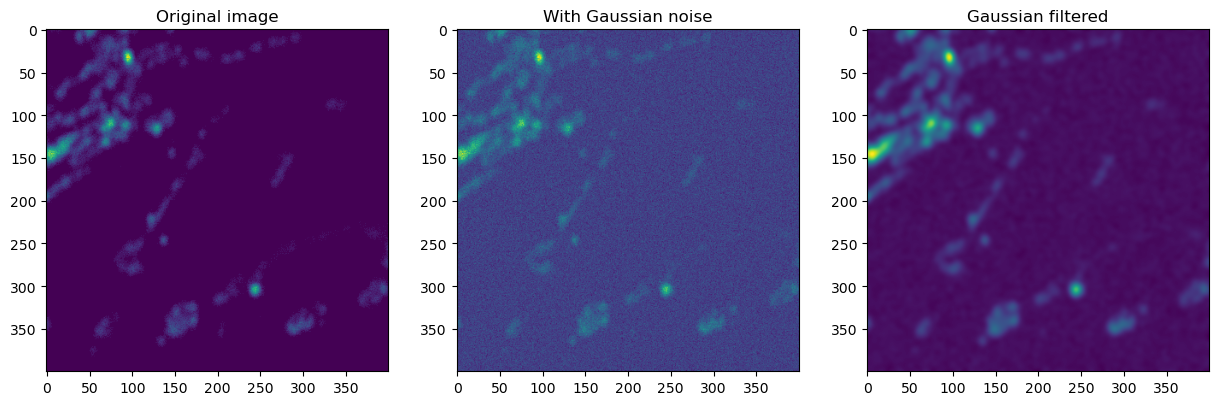

In [12]:
from skimage import filters
from skimage import restoration


sigmacyx=[0,3,3]
noisy_gauss_gaussian_filtered=filters.gaussian(noisy_gauss_img, sigma=sigmacyx)
noisy_poisson_gaussian_filtered=filters.gaussian(noisy_poisson_img, sigma=sigmacyx)


# Gaussian filtering of data with Gaussian noise
fig, axs = plt.subplots(1, 3)
ax1=axs[0].imshow(myimgzoom[0,:,:])              # original image
ax2=axs[1].imshow(noisy_gauss_img[0,:,:])    # with addition Gaussian noise
ax3=axs[2].imshow(noisy_gauss_gaussian_filtered[0,:,:])  # after application of Poisson noise
   
axs[0].set_title('Original image')
axs[1].set_title('With Gaussian noise')
axs[2].set_title('Gaussian filtered')

fig.set_size_inches(15, 8)



### Median filter
Different techniques for noise filtering are median and total variation (TV) filtering. With the median filter, each output pixel is computed as the median value of the input pixel under a chosen window. With TV filtering technique, the output image is an approximation of the input noisy image, which has a smaller total variation than the input image but is similar to the image. A total variation of an image measures how much the image changes between pixel values.

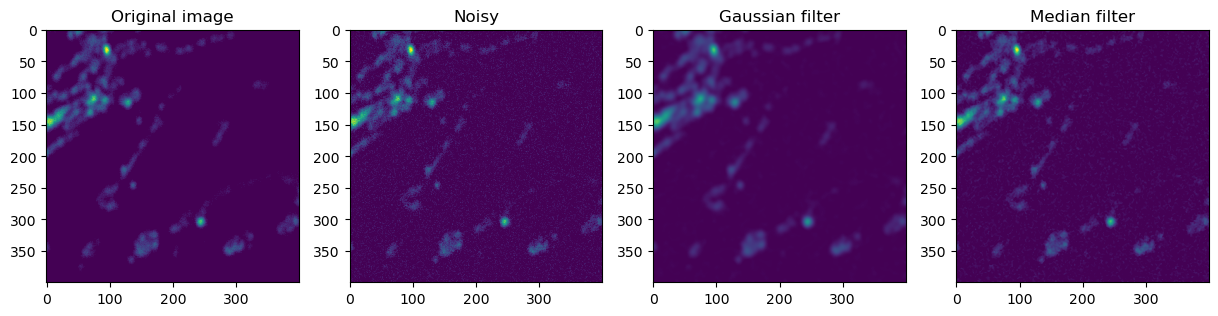

In [14]:
k = 0 # choose to display whichever channel you prefer [value between 0 and 3 for the particular data in this notebook]
rangemin=0
rangemax=17

# MEDIAN FILTERING
noisy_gauss_median_filtered=filters.median(noisy_gauss_img[k,:,:], np.ones((3,3))) # second argument in this function here defines the size of the Kernel over which the median is calculated
noisy_poisson_median_filtered=filters.median(noisy_poisson_img[k,:,:],  np.ones((3,3)))


fig, axs = plt.subplots(1, 4)
ax1=axs[0].imshow(myimgzoom[k,:,:],  vmin =rangemin, vmax=rangemax)              # original image
ax2=axs[1].imshow(noisy_gauss_img[k,:,:],  vmin =rangemin, vmax=rangemax)    
ax3=axs[2].imshow(noisy_gauss_gaussian_filtered[k,:,:], vmin =rangemin, vmax=rangemax)    
ax4=axs[3].imshow(noisy_gauss_median_filtered, vmin =rangemin, vmax=rangemax)   

axs[0].set_title('Original image')
axs[1].set_title('Noisy')
axs[2].set_title('Gaussian filter')
axs[3].set_title('Median filter')



fig.set_size_inches(15, 8)


# Segmentation

- what is segmentation
- what is a mask , label mask, ROI

The goal is to find masks which represents each ROI. The easiest way to do this by simply thresholding the intensity of the image. By this, the mask is defined such that only intensity (pixel) values greater than the threshold value are selected. If we stop at this stage, the problem we may encounter is such that some values within the thresholded region may get discarded because the intensity value is lower than the threshold and the ROI won't be filled. In this case, we may need to find the edge or/and fill the mask region. Another issue that we may encounter as well is that the edges of the regions may overlap so they may be detected or segmented as one. One solution in this case is to use what is called watershed segmentation to detect the flow of the intensity and decide from there whether the regions form only one object or different objects. 


## Static Thresholding 


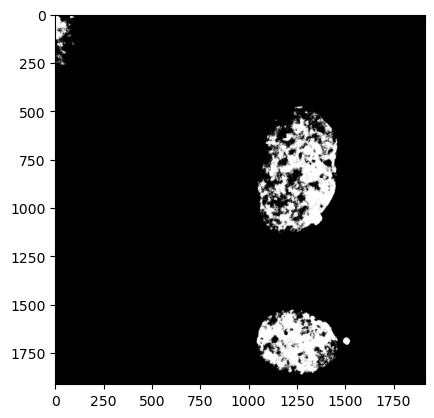

In [16]:
mydata =  AICSImage('data/airyscan-4colors.tif')
myimg = mydata.data
myimg = myimg[0,:,0,:,:]

nuclei=myimg[3,:,:]             # the object we want to segment and set as markers of our final ROI
thresholdmask=nuclei>=10        # change threshold value here to see what happens to the thresholdmask that is being displayed below
plt.imshow(thresholdmask,cmap='gray')
plt.show()

## Automated thresholding segmentation 
There is also one way to automatically detect the threshold that needs to be applied on the image in order to detect the nuclei region. This method was developed by Otsu and you can follow the link [here](https://en.wikipedia.org/wiki/Otsu%27s_method) if you want to learn more how does it work. So let us see now how can we do the thresholding using the Otsu's method and fill the mask. And since in microscopic images, we may have more than one nuleus (in our case we do have 2 full ones), we need to label each of the nuclei to distingush them and to be able to extract information from each of them. To achieve these, we need to load some packages first. 

In [17]:
# PACKAGES
from skimage.filters import threshold_otsu                          # Otsu's threshold
from skimage.morphology import closing, square                      # To close the region we just obtained from the thresholding
from skimage.segmentation import clear_border                       # To remove artifacts connected to image border
from skimage.measure import label, regionprops_table, regionprops, find_contours       # To label the nucleis, measure information about regions, find the countours of each region
from skimage.color import label2rgb                                 # To attribute colors to the labelled regions
from skimage import morphology                                      # A collection of non-linear operations related to the shape or morphology of features in an image
from scipy import ndimage as ndi                                    # Package contains functions for multidimensional image processing 
from skimage.segmentation import watershed                          # For watershed segmentation
from skimage import measure 
from skimage.feature import blob_dog                                # For blob or spot detection using the difference of Gaussian method                                        # For measuring the image properties. Package contains the regionprops function that we will use for statistical analysis in the image


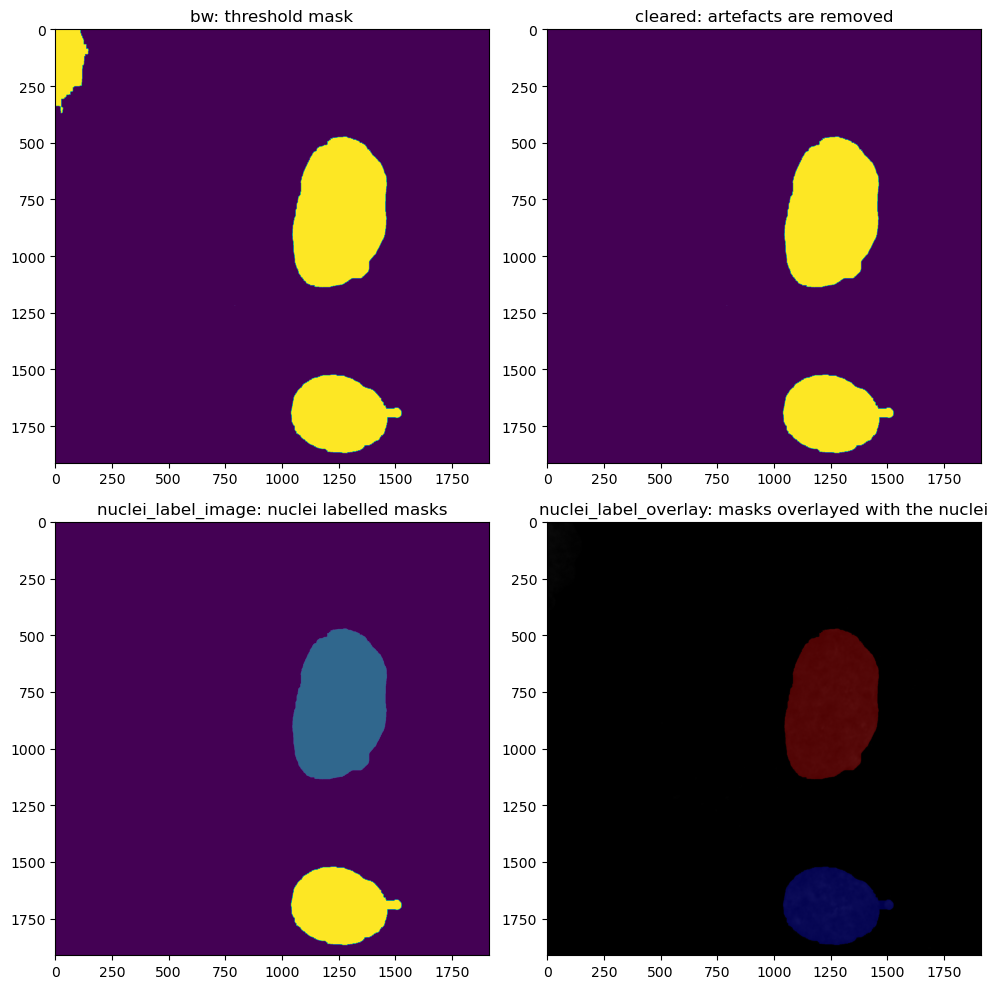

In [18]:
# find the threshold value differentiating the signal from background
thresh = threshold_otsu(nuclei) 

# define the threshold mask and close it
bw = closing(nuclei > thresh, square(35)) 

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
nuclei_label_image = label(cleared) 

# remove small objects that may still be present in the masks and only keep the two biggest regions
props = regionprops(nuclei_label_image, nuclei)   # measure the image properties of the labelled regions within the nuclei
area_labeleled_regions = [p.area for p in props]  # extract the areas of the labelled images
area_labeleled_regions = sorted(area_labeleled_regions) # sort the list of areas so that we can have the two biggest regions at the end of the list
nuclei_label_image = morphology.remove_small_objects(nuclei_label_image, min_size=area_labeleled_regions[-1-2]+1) # remove small objects with size smaller than the defined min_size

# label image to rgb 
nuclei_label_overlay = label2rgb(nuclei_label_image, image=nuclei, bg_label=0)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(bw)
ax[0,0].set_title('bw: threshold mask')

ax[0,1].imshow(cleared)
ax[0,1].set_title('cleared: artefacts are removed')

ax[1,0].imshow(nuclei_label_image)
ax[1,0].set_title('nuclei_label_image: nuclei labelled masks')

ax[1,1].imshow(nuclei_label_overlay)
ax[1,1].set_title('nuclei_label_overlay: masks overlayed with the nuclei')


plt.tight_layout()
plt.show()

## Watershed-based segmentation
The segmentation of the nuclei is pretty straightforward because they are well separated. In same cases however, the objects we want to segment overlap, making it difficult to discern the different regions. In this case, we would need to add extra step into the image segmentation in order to discern the objects. Watershed segmentation is useful for this purpose. It is generally used for separating different objects. Watershed algorithm treats pixels values as a local topography (elevation) so the goal is to follow the flow of the elevation and find the watershed lines from which the edge of each of the regions are deduced. We use this principle to extract our previously defined ROIs: the actin region in Channel-1 having the two nuclei as markers and the seeds of the segmentation. 

The steps that we need to follow for this are as follows: 
*  Step 1: threshold the actin to segment to obtain a region mask denoted by actin_mask from it
*  Step 2: calculate the distance transform of actin_mask, also known as distance map, which defines the spatial distance of each pixel value position to the background of the image
*  Step 3: define the markers or seeds of the segmentation as local maxima of the distance to the background (local minima of the image to segment and the opposite of the distance). We have this as the nuclei_label_image. 
*  Step 4: watershed the opposite of the distance transform from Step 2 within the mask in Step 1 and the nuclei markers 

Text(0.5, 1.0, 'nuclei as seeds')

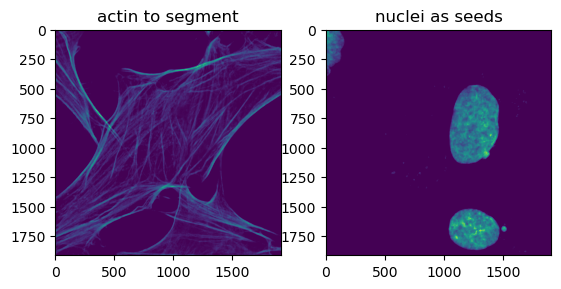

In [19]:
actin = myimg[1,:,:] # the regions we want to segment 
fig, axs = plt.subplots(1,2)
axs[0].imshow(actin)
axs[0].set_title('actin to segment')

axs[1].imshow(nuclei)
axs[1].set_title('nuclei as seeds')


#### Mask in the actin Channel
Create a mask on the actin using thresholding and morphological operations for closing and filling the mask. In the morphological operations, the erosion and dilation operations are used. Erosion removes small objects so only the big objects will remain in the image while dilation makes small objects more visible and fills in small holes in objects. A successive operation of those two operations dilation followed by an erosion constitutes the closing function.

The dynamic range of the intensity values of the actin image is low. The image also has a 8 bit depth. Because of these, we needed to do a lot of filtering to smooth the image and still did not obtain a good mask which can accurately covers the actins (see the figure representing the filled and closed mask above). A solution to this can consist of increasing the bit depth, hence the dynamic range, and blurring the image using a Gaussian filter afterwards. We convert the 8-bit image into 32-bit floating point.

In [20]:
# convert 8-bit into 32-bit floating point
print('(min, max) of the dynamic range =', (np.min(actin), np.max(actin)))
print('bit depth: ', actin.dtype)

actin_float = actin.astype(np.float32)
print('bit depth: ', actin_float.dtype)

(min, max) of the dynamic range = (0, 49)
bit depth:  uint8
bit depth:  float32


Text(0.5, 1.0, 'filled actin_mask')

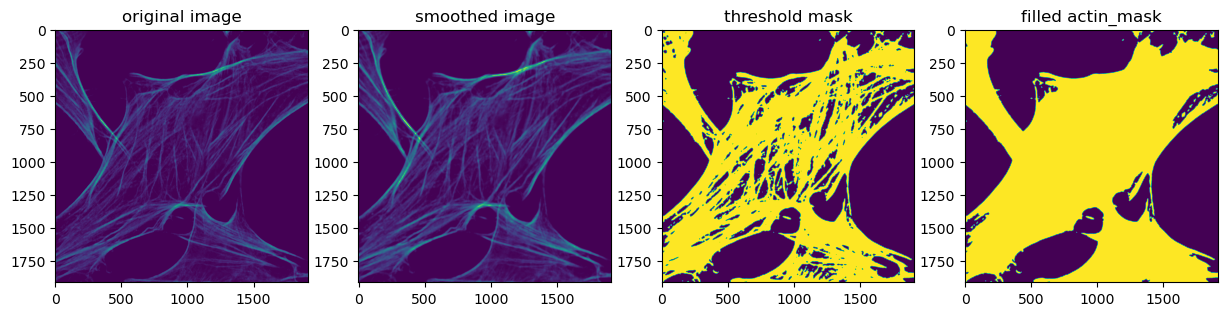

In [21]:
# smoothed the image using the Gaussian filter with the same sigma as before
smooth_actin = ndi.gaussian_filter(actin_float, sigma=3)
# find the optimal threshold
thresh = 1 #threshold_otsu

# define the threshold mask
thresh_mask = smooth_actin > thresh 

# fill holes to form the the actin_mask without performing the closing function
actin_mask = ndi.binary_fill_holes(thresh_mask).astype(int)

fig, axs = plt.subplots(1,4, figsize=(15, 15))
axs[0].imshow(actin)
axs[0].set_title('original image')

axs[1].imshow(smooth_actin)
axs[1].set_title('smoothed image')

axs[2].imshow(thresh_mask)
axs[2].set_title('threshold mask')

axs[3].imshow(actin_mask)
axs[3].set_title('filled actin_mask')

#### Distance transform and Watershed
The next step will consists of computing the distance transform of the actin mask. An an exercise, observe how the value of the distance inside the regions change with the spatial coordinates. 

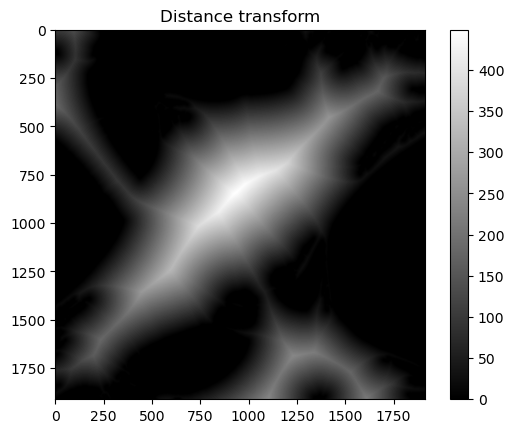

In [22]:
distance = ndi.distance_transform_edt(actin_mask) 

plt.imshow(distance, cmap=plt.cm.gray)
plt.title('Distance transform')
plt.colorbar()
plt.show()

Now we set the nuclei we segemented before as the markers or seeds of the segmentations. We use the markers to label the segmented regions in the actin region. 
After, we watershed the negative inverse of the distance transform of the actin using the defined markers and within the mask delimited by the actin. The negative inverse of the distance is used in the watershed function instead of the distance because the goal is to have the objects region as valleys not peak.  

Text(0.5, 1.0, 'Segmented ROIs')

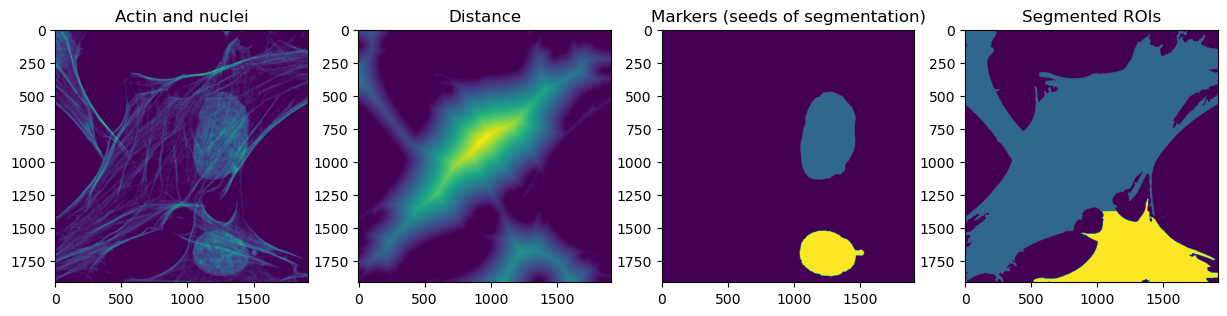

In [23]:
watershed_ROIs_image = watershed(-distance, markers=nuclei_label_image, mask=actin_mask)

fig, axs = plt.subplots(1,4, figsize=(15, 15))
axs[0].imshow(actin+nuclei)
axs[0].set_title('Actin and nuclei')

axs[1].imshow(distance)
axs[1].set_title('Distance')

axs[2].imshow(nuclei_label_image)
axs[2].set_title('Markers (seeds of segmentation)')

axs[3].imshow(watershed_ROIs_image)
axs[3].set_title('Segmented ROIs')

## Spot detection

To do the spot detection, we need to use what is called blob detection. Blob stands for Binary Large Object and refers to the connected pixel in the binary image. The blob detection method aims at detecting regions in a digital image that differ in properties, such as brightness or color, compared to surrounding regions. The Difference of Gaussian (DoG) method is one technique to detect blobs. For each blob found (a spot in our case), the method returns its coordinates position and the standard deviation of the Gaussian kernel that detected the spot. 


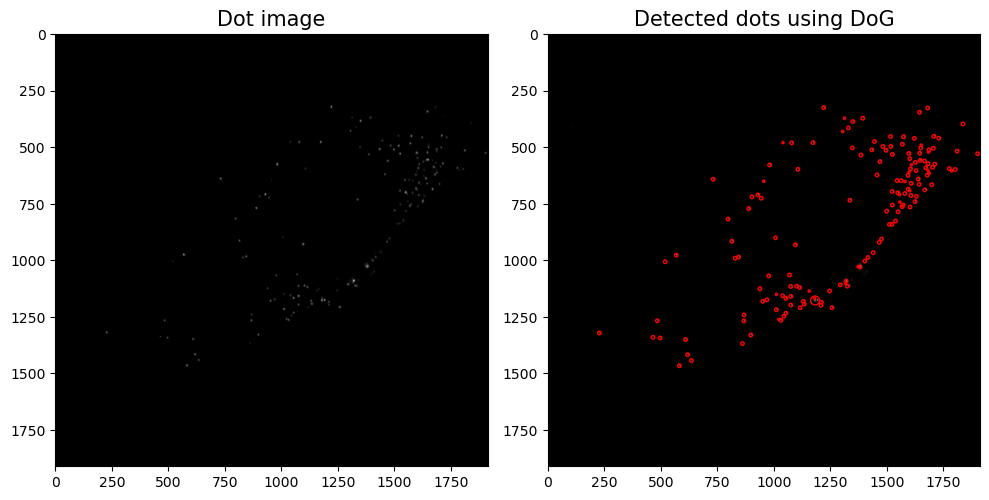

In [24]:
dotsimage = myimg[2,:,:] # the image containing the dot spot we want to detect

# Difference of Gaussian (DOG)
y_x_sigmas_dots = blob_dog(dotsimage, max_sigma=10, threshold=0.01) # 

# Display results
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].set_title('Dot image',fontsize=15)
ax[0].imshow(dotsimage,cmap='gray')

ax[1].imshow(dotsimage, cmap='gray') # same image on which the circle is to overlay on
for coord in y_x_sigmas_dots:
    y, x, sigma = coord              # outputs of the DoG blob detection: y,x coordinates and std of the Gaussian kernel
    ax[1].add_patch(plt.Circle((x, y), sigma*3, color='r',  # display of the circle centered at the (y,x) coordinates and with radius sigma*3
                            fill=False))
ax[1].set_title('Detected dots using DoG',fontsize=15)

plt.tight_layout()
plt.show()

## Segmentation using Cellpose

In [25]:

from cellpose import models

model = models.Cellpose(gpu=True, model_type='cyto2')
tmp = img[0,[1,3],0,::4,::4]
mask, flows, styles, diams = model.eval(tmp, channels=[1,2],diameter=200,cellprob_threshold=2)
fig, ax = plt.subplots(1,4)
ax[0].imshow(tmp[0])
ax[1].axis('off')
ax[1].imshow(mask)
ax[1].axis('off')
ax[1].set_title('Labels')
ax[2].imshow(flows[0])
ax[2].axis('off')
ax[2].set_title('Flows')
ax[3].imshow(flows[2])
ax[3].axis('off')
ax[3].set_title('Probability')
fig.tight_layout()

100%|██████████| 25.3M/25.3M [00:01<00:00, 17.6MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 23.0MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 24.5MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 24.2MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 4.55MB/s]


TypeError: 'AICSImage' object is not subscriptable

# Measure image properties

Now let use the ROI masks that we have just segmented and do the measurement we previously defined as our problems. For this, we use the regionprops function to measure the properties of the signal within the ROI mask. Below we display the countours of the ROIs.

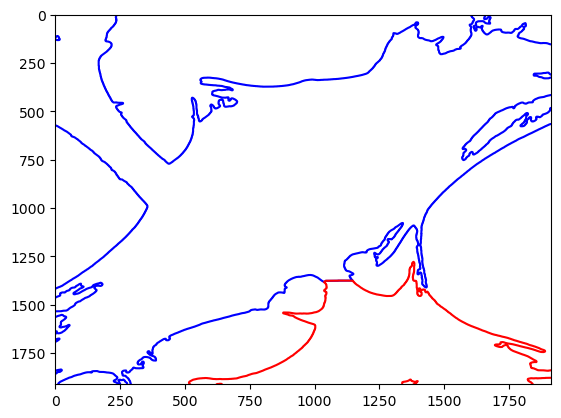

In [26]:
props = regionprops(watershed_ROIs_image,actin) # signal property: first argument is the mask ROI, second argument is the signal from which we are to extract any information of interest from

color_list = ['blue', 'red'] # to distinguish the countours of the two regions 

color_indx = 0

for p in props:
    c = find_contours(watershed_ROIs_image==p.label,0.5)
    for ck in c:
        plt.plot(ck[:,1],ck[:,0], color=color_list[color_indx])
    color_indx = color_indx + 1
plt.xlim(0, actin.shape[0])
plt.ylim(0, actin.shape[1])
plt.gca().invert_yaxis()

## Maximum Intensity


In [27]:
signal = myimg[0,:,:] # the signal from which we want to do the measurement from
props = regionprops_table(watershed_ROIs_image,signal, properties=('max_intensity','label'))

print(props)


print(props['label'])
print(props['label'][0])

list_max_int=props['max_intensity']


{'max_intensity': array([19., 12.]), 'label': array([1, 3])}
[1 3]
1


## Medium Intensity

The information about the median is  not included in the image property that we can retrieve from regionprops. So here we show how can we do it using the information we can extract from the regionprops and numpy. The median of a list is defined as the middle element of the list when the list is sorted. 

In [28]:
signal = myimg[1,:,:] # the signal from which we want to do the measurement from

def median_intensity(regionmask, intensity_image):
        return np.median(intensity_image[regionmask])


props = regionprops_table(watershed_ROIs_image, signal, extra_properties=(median_intensity,))

list_median_int=props['median_intensity']

print('The median intensity for each regions are: ',list_median_int)

The median intensity for each regions are:  [3. 3.]


## Number of dots
Now we are going to count how many dots are there in Channel-2 within the two regions defined by the ROIs. We use the knowledge we have acquired from Section. Spot detection to complete this task.


In [29]:
signal = myimg[2,:,:] # the signal from which we want to do the measurement from



props = regionprops(watershed_ROIs_image, signal)
props = regionprops_table(watershed_ROIs_image, signal,properties=('image_intensity','label') )

dots_number = [] # list where we want to store the number of dots of each ROI


for p in props['image_intensity']:
    iint = p # extract the image intensity within each of the ROIs
    y_x_sigmas_dots_ROI = blob_dog(iint, max_sigma=10, threshold=0.01) # detect the dots in the ROI
    dots_number.append(y_x_sigmas_dots_ROI.shape[0]) # the number of coordinates position gives us the number of dots

plt.show()


print('The number of dots in each regions are: ', dots_number)

The number of dots in each regions are:  [137, 0]


# Save the results

Generate a Data Frame.


In [30]:
import pandas as pd

plc_data = pd.DataFrame(columns=['Maximal_intensity', 'Median','Spot number'], dtype=object) # create a table
data = {'Maximal_intensity':list_max_int, 'Median': list_median_int, 'Spot number':dots_number}
plc_data = pd.DataFrame(data=data)
plc_data

,Maximal_intensity,Median,Spot number
0,19.0,3.0,137
1,12.0,3.0,0


Save results in  csv file.

In [35]:
destinationfile='data/new_discovery.xlsx'
plc_data.to_csv(destinationfile)

# Some more helpful tips

- take good images
- housekeeping genes